In [2]:
import numpy as np, pandas as pd, yfinance as yf, matplotlib.pyplot as plt, statistics

#declare constants
nprime, a, b, c, d, nInit, minCompt, v1, v2, nMax = 300, 4, 1, 1, -49, 10, 5, 1, 1, 100

#dataframes for parameters
nt, ma, sig, compteur, lambd, epsilon, delta, epsilonp, n, npr, pos = ([None for i in range(nMax)] for i in range(11))

#retrieve underlying asset
asset = yf.download("EURUSD=X")['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
def computeStrategy(incrementsMode, rebaseMode):
    
    globals()['nt'], globals()['ma'], sig, compteur, lambd, epsilon, delta, epsilonp, n, npr, pos = ([None for i in range(nMax)] for i in range(11))
    
    #compute increments
    if incrementsMode == 'absolu':
        increments = asset.diff()
    elif incrementsMode == 'log':
        increments = np.log10(asset / asset.shift(1))
    increments[0] = 0
    
    #compute rebase
    rebase = pd.DataFrame(index = asset.index, columns = ['rebase'])
    if rebaseMode == 'reel' and incrementsMode == 'log':
        rebase.iloc[0]['rebase'] = 100
        for i in range(1, len(increments)):
            rebase.iloc[i]['rebase'] = rebase.iloc[i - 1]['rebase'] * np.exp(increments[i])
    else:
        rebase.iloc[0]['rebase'] = asset[0]
        for i in range(1, len(increments)):
            rebase.iloc[i]['rebase'] = rebase.iloc[i - 1]['rebase'] + increments[i]
    incrementssquared = np.square(increments)
    
    for i in range(nMax, len(asset)):

        #fill nt df
        if nt[i - 1] == None:
            nt.append(nInit)
        else:
            nt.append(round(min(nMax, max(nInit, (a * (compteur[i - 1] * (lambd[i - 1] ** (v1 * (abs(npr[i - 1]) ** (1/v2))))) + b) ** c + d))))
    
        #fill sig df
        ewma = np.sqrt(incrementssquared.iloc[int(i - nt[i]) : i].ewm(alpha = 2 / (1 + nt[i])).mean())
        sig.append(ewma[len(ewma) - 1])
    
        #fill ma df
        maAlpha = 2 / (1 + nt[i])
        maEwma = rebase.iloc[int(i - nt[i]) : i].ewm(alpha = maAlpha).mean()
        ma.append(maEwma.iloc[len(maEwma) - 1]['rebase'])
        
        #fill delta df
        delta.append(((nprime * nt[i]) ** 0.25) * sig[i])

        #fill epsilon df
        epsilon.append((rebase.iloc[i]['rebase'] - ma[i]) / delta[i])
        
        #fill epsilonprime df
        epsilonp.append(np.sign(epsilon[i]) * min(1, abs(epsilon[i])))
        
        #fill compteur df
        if nt[i - 1] == None:
            compteur.append(0)
        else:
            if (epsilon[i] * epsilon[i - 1]) <= 0:
                compteur.append(0)
            else:
                compteur.append(compteur[i - 1] + 1)
        
        if compteur[i] != 0:
            start = i - compteur[i]
            end = i
        else:
            start = i
            end = i + 1
        
        #fill n df
        if epsilon[i] > 0:
            n.append(np.max(epsilon[start : end]))
        else:
            n.append(np.min(epsilon[start : end]))
        
        #fill nprime df
        if epsilonp[i] > 0:
            npr.append(np.max(epsilonp[start : end]))
        else:
            npr.append(np.min(epsilonp[start : end]))
        
        #fill lambda df
        try:
            lambd.append(epsilon[i] / n[i])
        except:
            lambd.append(1)
        
        #fill pos df
        if compteur[i] < minCompt:
            pos.append(0)
        else:
            pos.append(min(1, max(-1, np.sign(epsilon[i]))))
        
    print("Custom strategy computed with avg error : {}/day - Average counter : {}".format(round(sum(abs(asset[nMax : len(asset)] - ma[nMax : len(ma)])) / (len(asset) - nMax), 2), round(sum(nt[nMax : len(nt)]) / (len(nt) - nMax), 2)))
    return ma

def graphStrategy(startDate, endDate, strat):
    plot_asset = asset[np.logical_and(asset.index > np.datetime64(startDate), asset.index < np.datetime64(endDate))]
    ma_asset = pd.DataFrame(strat, index = asset.index)[np.logical_and(asset.index > np.datetime64(startDate), asset.index < np.datetime64(endDate))]
    plt.figure(figsize = (15, 8))
    plt.plot(plot_asset.index, plot_asset)
    plt.plot(plot_asset.index, ma_asset)
    plt.legend(['EUR/USD','Moving average'])
    plt.show()
    
def mesaAdaptiveMovingAverage(fastLimit, slowLimit, data):

    s = np.zeros(len(data))  # smooth
    d = np.zeros(len(data))  # detrenders
    p = np.zeros(len(data))  # periods
    sp = np.zeros(len(data))  # smoothed periods
    ph = np.zeros(len(data))  # phases
    q1 = np.zeros(len(data))  # q1
    q2 = np.zeros(len(data))  # q2
    i1 = np.zeros(len(data))  # i1
    i2 = np.zeros(len(data))  # i2
    re = np.zeros(len(data))  # re
    im = np.zeros(len(data))  # im

    MAMA = np.zeros(len(data))  # MAMA out
    FAMA = np.zeros(len(data))  # FAMA out

    # --- get first non nan index
    for i in range(len(data)):

        if np.isnan(data[i]) == False:

            firstNonNan = i
            break

    # --- get last non nan index
    for i in reversed(range(len(data))):

        if np.isnan(data[i]) == False:

            lastNonNan = i
            break

    # --- calculate MAMA and FAMA
    for i in range(len(data)):

        if i < firstNonNan:
            MAMA[i] = np.nan
            FAMA[i] = np.nan

        elif i > lastNonNan:
            MAMA[i] = np.nan
            FAMA[i] = np.nan

        elif i > firstNonNan + 4:

            s[i] = (4 * data[i] + 3 * data[i - 1] + 2 * data[i - 2] + data[i - 3]) / 10
            d[i] = (
                0.0962 * s[i]
                + 0.5769 * s[i - 2]
                - 0.5769 * s[i - 4]
                - 0.0962 * s[i - 6]
            ) * (0.075 * p[i - 1] + 0.54)

            # Compute InPhase and Quadrature components
            q1[i] = (
                0.0962 * d[i]
                + 0.5769 * d[i - 2]
                - 0.5769 * d[i - 4]
                - 0.0962 * d[i - 6]
            ) * (0.075 * p[i - 1] + 0.54)
            i1[i] = d[i - 3]

            # Advance the phase of I1 and Q1 by 90 degrees
            ji = (
                0.0962 * i1[i - i]
                + 0.5769 * i1[i - 2]
                - 0.5769 * i1[i - 4]
                - 0.0962 * i1[i - 6]
            ) * (0.075 * p[i - 1] + 0.54)
            jq = (
                0.0962 * q1[i - i]
                + 0.5769 * q1[i - 2]
                - 0.5769 * q1[i - 4]
                - 0.0962 * q1[i - 6]
            ) * (0.075 * p[i - 1] + 0.54)

            # Phasor addition for 3 bar averaging
            _i2 = i1[i] - jq
            _q2 = q1[i] + ji

            # Smooth the I and Q components before applying the discriminator
            i2[i] = 0.2 * _i2 + 0.8 * i2[i]
            q2[i] = 0.2 * _q2 + 0.8 * q2[i]

            # Homodyne Discriminator
            _re = i2[i] * i2[i - 1] + q2[i] * q2[i - 1]
            _im = i2[i] * q2[i - 1] + q2[i] * i2[i - 1]
            re[i] = 0.2 * _re + 0.8 * re[i - 1]
            im[i] = 0.2 * _im + 0.8 * im[i - 1]

            # set period value
            period = 0
            if _im != 0 and _re != 0:
                period = 360 / np.arctan(_im / _re)
            if period > 1.5 * p[-1]:
                period = 1.5 * p[i - 1]
            if period < 0.67 * p[i - 1]:
                period = 0.67 * p[i - 1]
            if period < 6:
                period = 6
            if period > 50:
                period = 50
            p[i] = 0.2 * period + 0.8 * p[i - 1]
            sp[i] = 33 * p[i - 1] + 0.67 * sp[i - 1]

            if i1[i] != 0:
                ph[i] = np.arctan(q1[i] / i1[i])

            # delta phase
            deltaPhase = ph[i - 1] - ph[i]
            if deltaPhase < 1:
                deltaPhase = 1

            # alpha
            alpha = fastLimit / deltaPhase
            if alpha < slowLimit:
                aplha = slowLimit

            # add to output using EMA formula
            MAMA[i] = alpha * data[i] + (1 - alpha) * MAMA[i - 1]
            FAMA[i] = 0.5 * alpha * MAMA[i] + (1 - 0.5 * alpha) * FAMA[i - 1]

    print('MAMA/FAMA strategies computed')
    return MAMA, FAMA

#Backtesting strategy
#Assumption : no fee
def backtestStrategy(asset, ma, nMax, title):
    
    profit, last = [0 for i in range(nMax + 1)], 0.5
    benef, waitingLong, waitingShort, fullLong, fullShort, tradingPositions = ([] for i in range(6))
    investment = 0 # en EUR
    
    for i in range(nMax + 1, len(asset)):
        
        #CROSS EUR baisse -> SHORT
        if ma[i] >= asset[i] and ma[i - 1] < asset[i - 1]:
            investment += 100
            waitingShort.append(asset[i])
            
        #CROSS  EUR monte -> LONG
        if ma[i] <= asset[i] and ma[i - 1] > asset[i - 1]:
            investment += 100
            waitingLong.append(asset[i])
            
        upMove = sum([1 for i in range(i - 10, i + 1) if asset[i] > asset[i - 1]])
        for short in waitingShort:
            if asset[i] <= short and upMove <= 5:
                if (short - asset[i]) < (short - asset[i - 1]) and (short - asset[i - 1]) > (short - asset[i - 2]):
                    benef.append(100 * (short - asset[i]) / asset[i])
                    waitingShort.remove(short)
                    fullShort.append(100 * (short - asset[i]) / asset[i])
                
        for long in waitingLong:
            if asset[i] >= long and upMove >= 5:
                if (asset[i] - long) < (asset[i - 1] - long) and (asset[i - 1] - long) > (asset[i - 2] - long):
                    benef.append(100 * (asset[i] - long) / asset[i])
                    waitingLong.remove(long)
                    fullLong.append(100 * (asset[i] - long) / asset[i])
            
        tradingPositions.append(last)
        profit.append(sum(benef))
    
    sharpe_ratio = ((sum(benef)) / investment) / statistics.stdev(benef)
    print("Investment : {} € - Profit : {} €\nReturn on equity : {} % - Sharpe ratio : {} %\nAverage profit / position : {} €".format(round(investment, 2), round(sum(benef), 2),round(sum(benef) / investment * 100, 3) , round(sum(benef) / len(benef), 2), round(sharpe_ratio * 100, 3)))
    print('Long positions : {} Benefit : {} € - Short positions : {} Benefit : {} €\nNb positions not closed : {}'.format(len(fullLong), round(sum(fullLong), 2), len(fullShort), round(sum(fullShort), 2), len(waitingShort) + len(waitingLong)))
    
    plt.figure(figsize = (15, 8))
    plt.plot(benef)
    plt.yticks(fontsize=13)
    plt.title(title, fontsize = 20)
    plt.ylabel('Strategy benefit (€)', fontsize = 20)
    plt.axhline(y=0, color='black', linestyle='--')
    
    return profit

def computeKama(asset):
    periodsER = 10
    fastEMA = 2
    slowEMA = 30
    ER, SC = ([0 for i in range(periodsER)] for a in range(2))
    kama = [None for i in range(periodsER -1)]
    kama.append(asset[0:periodsER].rolling(window = periodsER).mean()[periodsER - 1])
    
    for i in range(periodsER, len(asset)):
        ER.append(abs(asset[i] - asset[i - periodsER]) / sum([abs(asset[i] - asset[i - t]) for t in range(1, periodsER + 1)]))
        SC.append(2 * (ER[i] * (2/3 - 2/31) + 2/31))
        kama.append(kama[i - 1] + SC[i] * (asset[i] - kama[i - 1]))
    
    print('KAMA computed')
    return kama

def plotProfitxAsset(profit, asset, start, end):
    plot_asset = asset[np.logical_and(asset.index > np.datetime64(start), asset.index < np.datetime64(end))]
    plot_profit = pd.DataFrame(profit, index = asset.index)[np.logical_and(asset.index > np.datetime64(start), asset.index < np.datetime64(end))]
    fig, ax = plt.subplots(figsize = (15, 8))
    ax.plot(plot_asset.index, plot_profit, 'y', label='Profit')
    ax2 = ax.twinx()
    ax2.plot(plot_asset.index, plot_asset, label = 'EUR/USD')
    ax.set_ylabel('Profit (€)', fontsize = 14)
    ax2.set_ylabel('EUR/USD', fontsize = 14)
    
def plotProfit(profits, legend):
    plt.figure(figsize = (15, 8))
    for profit in profits:
        plt.plot(asset.index, profit)
    plt.legend(legend, fontsize = 13)
    plt.title('Adaptive moving average strategies', fontsize = 20)
    plt.ylabel('Benefit (€)', fontsize = 14)
    plt.xticks(fontsize = 14)

In [4]:
MAMA, FAMA = mesaAdaptiveMovingAverage(0.5, 0.05, asset)
customStrat = computeStrategy('absolu', 'reel')
assetKama = computeKama(asset)

MAMA/FAMA strategies computed
Custom strategy computed with avg error : 0.01/day - Average counter : 10.27
KAMA computed


Investment : 89500 € - Profit : 923.35 €
Return on equity : 1.032 % - Sharpe ratio : 1.07 %
Average profit / position : 0.799 €
Long positions : 426 Benefit : 423.99 € - Short positions : 438 Benefit : 499.36 €
Nb positions not closed : 31


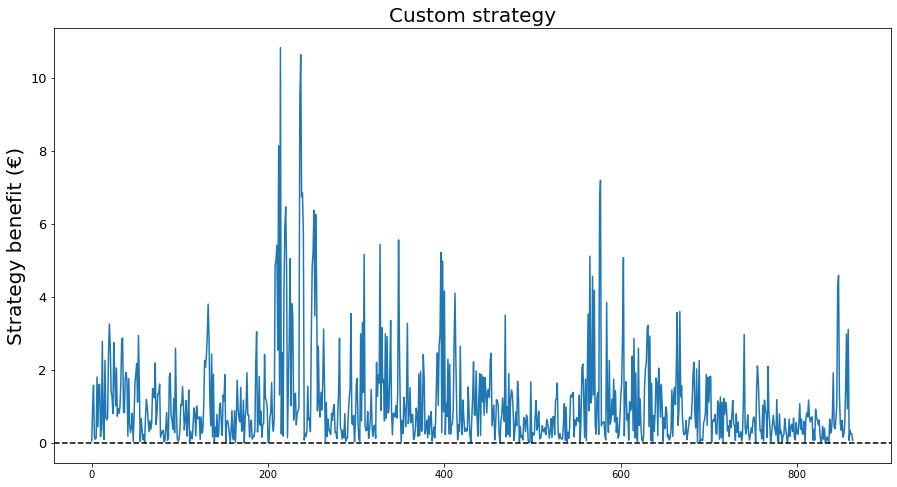

In [5]:
profitCustom = backtestStrategy(asset, ma, nMax, 'Custom strategy')

Investment : 140900 € - Profit : 1500.68 €
Return on equity : 1.065 % - Sharpe ratio : 1.11 %
Average profit / position : 0.769 €
Long positions : 661 Benefit : 648.86 € - Short positions : 691 Benefit : 851.82 €
Nb positions not closed : 57


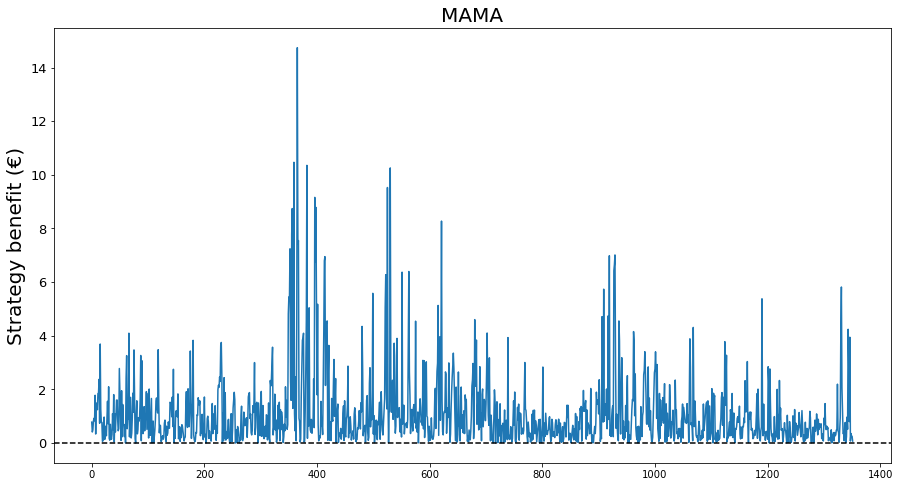

In [6]:
profitMama = backtestStrategy(asset, MAMA, 15, 'MAMA')

Investment : 84800 € - Profit : 877.73 €
Return on equity : 1.035 % - Sharpe ratio : 1.06 %
Average profit / position : 0.768 €
Long positions : 406 Benefit : 401.05 € - Short positions : 419 Benefit : 476.68 €
Nb positions not closed : 23


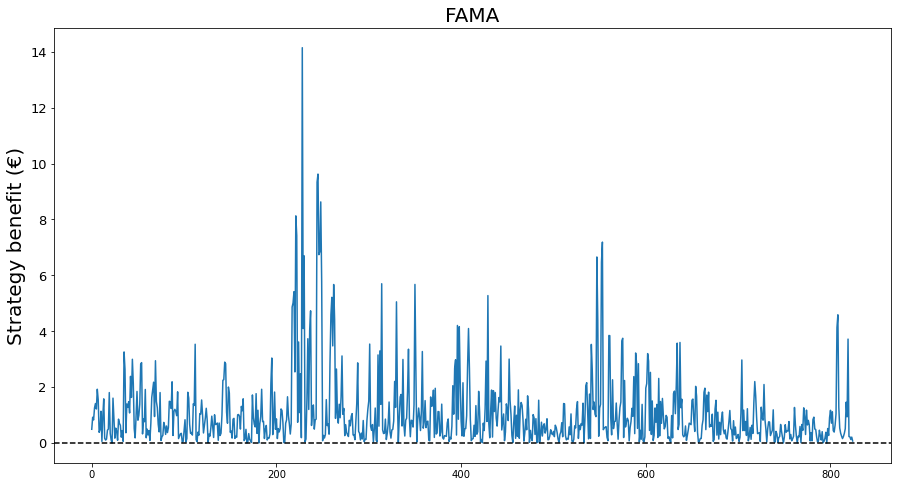

In [7]:
profitFama = backtestStrategy(asset, FAMA, 15, 'FAMA')

Investment : 104000 € - Profit : 1063.17 €
Return on equity : 1.022 % - Sharpe ratio : 1.06 %
Average profit / position : 0.812 €
Long positions : 493 Benefit : 480.51 € - Short positions : 510 Benefit : 582.66 €
Nb positions not closed : 37


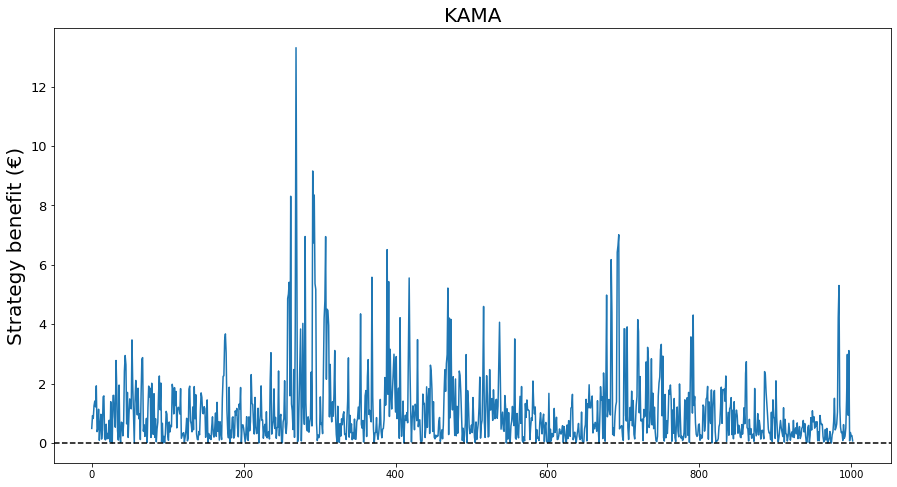

In [8]:
profitKama = backtestStrategy(asset, assetKama, 10, 'KAMA')

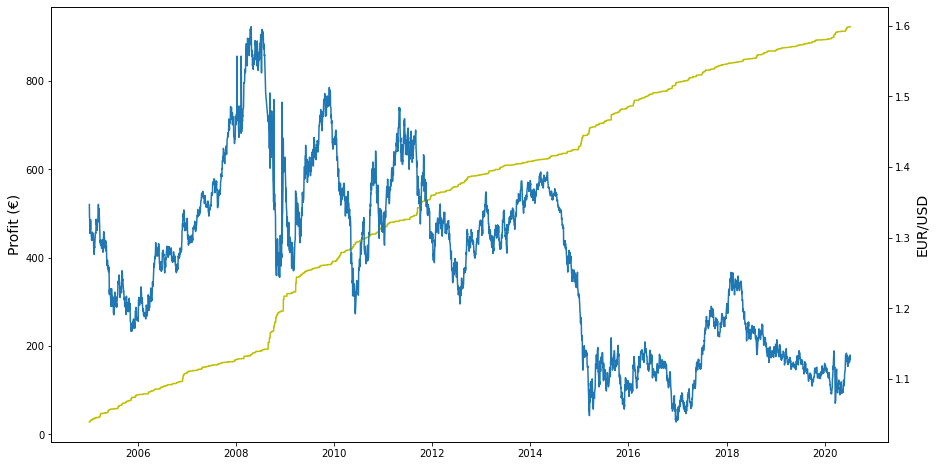

In [10]:
plotProfitxAsset(profitCustom, asset, '2005-01-01', '2021-01-01')

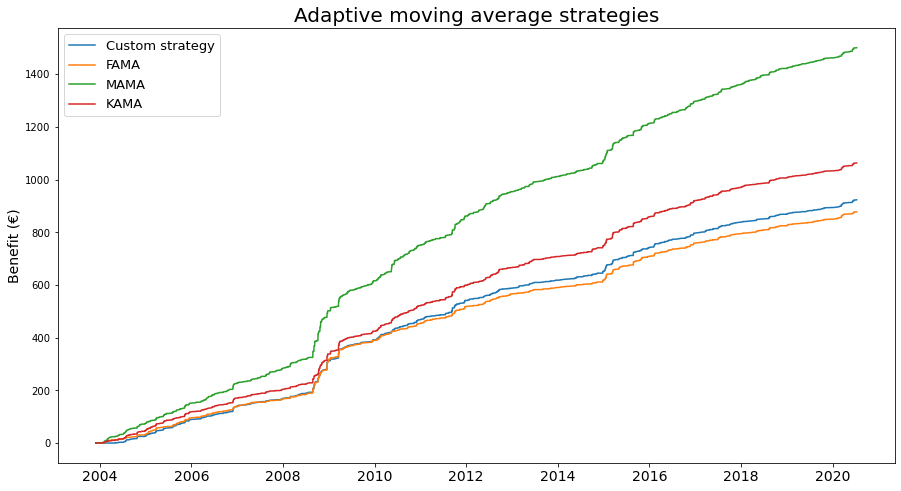

In [11]:
plotProfit([profitCustom, profitFama, profitMama, profitKama], ['Custom strategy', 'FAMA', 'MAMA', 'KAMA'])